<a href="https://colab.research.google.com/github/Onyimatics/cats_and_dogs_image_processing/blob/master/Best_Model_Cats_And_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# If you are using TensorFlow Keras
from tensorflow.keras import models, layers, regularizers

# If you are using Keras
from keras import models, layers, regularizers

import cv2
from skimage.feature import hog

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt

# library for evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# libraries for ML algorithms
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Imports
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

from random import randint
from random import seed

import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import hog
from random import seed, randint

# Set random seed for reproducibility
RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

img_dim = (150, 150)   # For CNN input

In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # unzip file
# import shutil
# shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/BCU/Applied AI/Image Processing Assessment/Prediction Challenge - Image Processing-20250218/data.zip', '/content/drive/MyDrive/Colab Notebooks/BCU/Applied AI/Image Processing Assessment/Prediction Challenge - Image Processing-20250218/', 'zip')

In [ ]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/BCU/Applied AI/Image Processing Assessment/Prediction Challenge - Image Processing-20250218/data'

In [ ]:
# load training data
df_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))

# summarise the details
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 10000


id label
0   1   cat
1   2   dog
2   3   cat
3   4   cat
4   5   cat

In [ ]:
# load testing data
df_test = pd.read_csv(os.path.join(data_folder, 'test.csv'))

# summarise the details
print(f'Number of entries: {len(df_test)}')
df_test.head()

Number of entries: 1000


id
0   1
1   2
2   3
3   4
4   5

<Axes: xlabel='label', ylabel='count'>

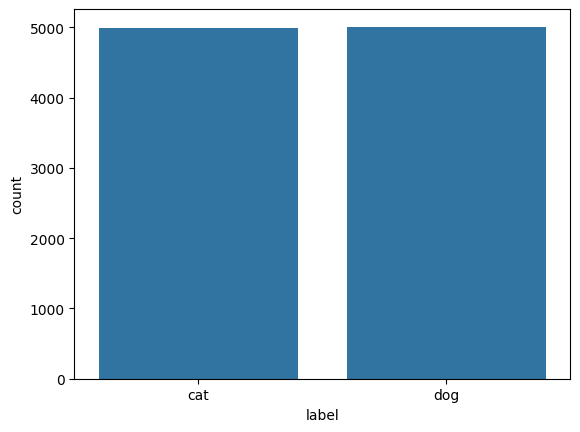

In [ ]:
# Summarise label details in training data
sns.countplot(x=df_train['label'])

In [ ]:
# method to load images in a folder
def load_images(ids, folder_path, dim=None):
  '''
  ids: list of image ids
  folder_path: path to image folder
  dim: dimensions to resize images (optional)
  '''
  images = []
  for id in tqdm(ids):
    image_path = os.path.join(folder_path, f'{id}.jpg')
    img = cv2.imread(image_path)

    # Resize if necessary
    if dim is not None:
      if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
        img = cv2.resize(img, dim)
    images.append(img)
  return images

In [ ]:
base_dim = (200, 200)

# load train images
train_image_folder = os.path.join(data_folder, 'train_images')
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = os.path.join(data_folder, 'test_images')
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

100%|██████████| 10000/10000 [1:17:50<00:00,  2.14it/s]


Number of training images loaded: 10000


100%|██████████| 1000/1000 [07:16<00:00,  2.29it/s]

Number of testing images loaded: 1000



Visualizing sample images:


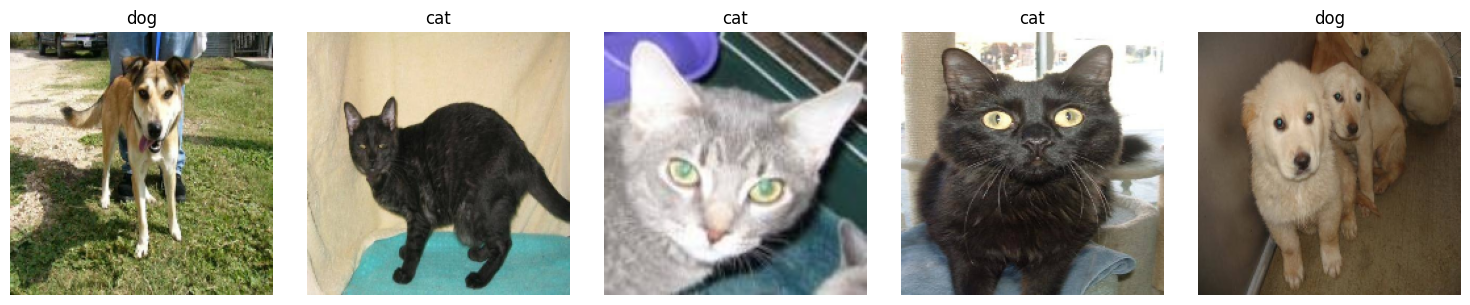

In [ ]:
# Visualize sample images
def visualize_samples(images, labels, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
        plt.title(labels[idx])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nVisualizing sample images:")
visualize_samples(train_images, df_train['label'])


*   **DATA PREPROCESSING**
*   **IMAGE MANIPULATION**
*   **FEATURE EXTRACTION**



In [ ]:
# Image Preprocessing Functions

# Method 1: Original RGB
def preprocess_original(images, target_size=(150, 150)):
    '''
    Original RGB images with normalization
    '''
    X = []
    for img in tqdm(images):
        # Resize and convert to RGB
        img_resized = cv2.resize(img, target_size)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        # Normalize to [0, 1]
        img_normalized = img_rgb / 255.0

        X.append(img_normalized)

    return np.array(X)

In [ ]:
# Method 2: Simple Grayscale
def preprocess_grayscale(images, target_size=(150, 150)):
    '''
    Simple grayscale conversion
    '''
    X = []
    for img in tqdm(images):
        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize
        img_resized = cv2.resize(img_gray, target_size)

        # Normalize to [0, 1]
        img_normalized = img_resized / 255.0

        # Reshape to have a single channel
        img_normalized = img_normalized.reshape(target_size + (1,))

        X.append(img_normalized)

    return np.array(X)

In [ ]:
# Method 2: Simple Grayscale
def preprocess_grayscale(images, target_size=(150, 150)):
    '''
    Simple grayscale conversion
    '''
    X = []
    for img in tqdm(images):
        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize
        img_resized = cv2.resize(img_gray, target_size)

        # Normalize to [0, 1]
        img_normalized = img_resized / 255.0

        # Reshape to have a single channel
        img_normalized = img_normalized.reshape(target_size + (1,))

        X.append(img_normalized)

    return np.array(X)

In [ ]:
# Method 3: Grayscale + Gaussian Blur
def preprocess_blur(images, target_size=(150, 150)):
    '''
    Grayscale + Gaussian blur
    '''
    X = []
    for img in tqdm(images):
        # Convert to grayscale and apply Gaussian blur
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_blur = cv2.GaussianBlur(img_gray, (3, 3), 2)

        # Resize
        img_resized = cv2.resize(img_blur, target_size)

        # Normalize to [0, 1]
        img_normalized = img_resized / 255.0

        # Reshape to have a single channel
        img_normalized = img_normalized.reshape(target_size + (1,))

        X.append(img_normalized)

    return np.array(X)

In [ ]:
# Method 4: Canny Edge Detection
def preprocess_edge(images, target_size=(150, 150)):
    '''
    Canny edge detection
    '''
    X = []
    for img in tqdm(images):
        # Convert to grayscale and apply Canny edge detection
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_edge = cv2.Canny(img_gray, 100, 200)

        # Resize
        img_resized = cv2.resize(img_edge, target_size)

        # Normalize to [0, 1]
        img_normalized = img_resized / 255.0

        # Reshape to have a single channel
        img_normalized = img_normalized.reshape(target_size + (1,))

        X.append(img_normalized)

    return np.array(X)

In [ ]:
# Method 5: HOG Feature Extraction
def preprocess_hog(images, target_size=(150, 150)):
    '''
    HOG feature visualization
    '''
    X = []
    for img in tqdm(images):
        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize for HOG
        img_resized = cv2.resize(img_gray, (64, 128))

        # Extract HOG features
        _, hog_img = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=True)

        # Normalize HOG image
        hog_img = (hog_img - hog_img.min()) / (hog_img.max() - hog_img.min())

        # Resize to target size
        hog_resized = cv2.resize(hog_img, target_size)

        # Reshape to have a single channel
        hog_resized = hog_resized.reshape(target_size + (1,))

        X.append(hog_resized)

    return np.array(X)

In [ ]:
# Method 6: Combined Grayscale and Edge
def preprocess_combined(images, target_size=(150, 150)):
    '''
    Combining grayscale and edge detection
    '''
    X = []
    for img in tqdm(images):
        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply Canny edge detection
        img_edge = cv2.Canny(img_gray, 100, 200)

        # Combine grayscale and edge
        img_combined = cv2.addWeighted(img_gray, 0.5, img_edge, 0.5, 0)

        # Resize
        img_resized = cv2.resize(img_combined, target_size)

        # Normalize to [0, 1]
        img_normalized = img_resized / 255.0

        # Reshape to have a single channel
        img_normalized = img_normalized.reshape(target_size + (1,))

        X.append(img_normalized)

    return np.array(X)


Visualizing preprocessing methods:


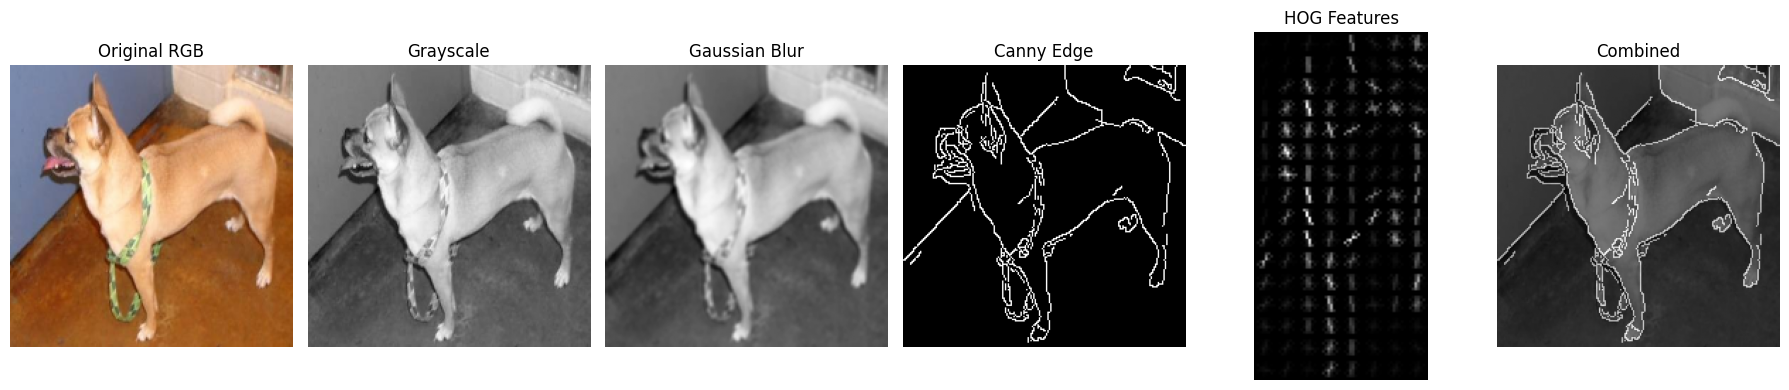

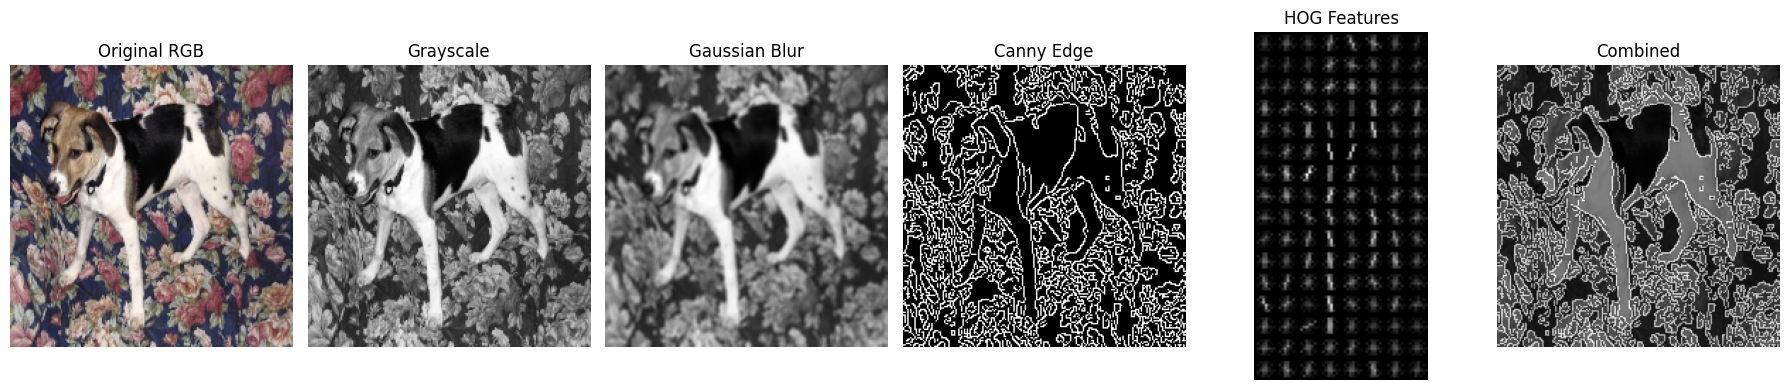

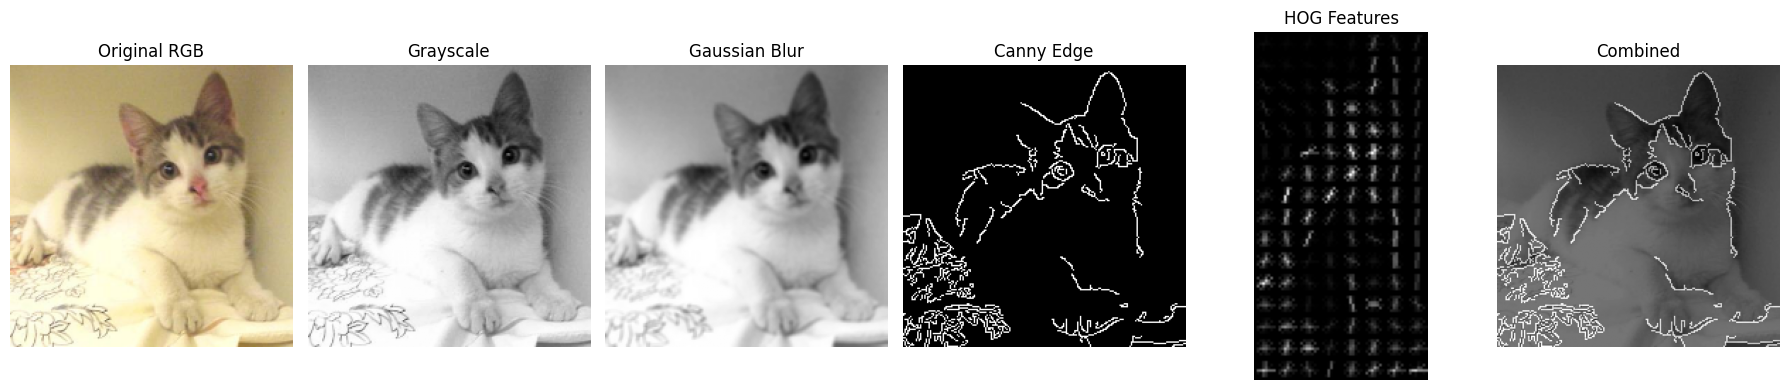

In [ ]:
# Visualize different preprocessing methods for sample images
def visualize_preprocessing_methods(images, num_samples=3):
    indices = np.random.choice(len(images), num_samples, replace=False)

    for idx in indices:
        img = images[idx]

        # Original RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Gaussian Blur
        img_blur = cv2.GaussianBlur(img_gray, (3, 3), 2)

        # Canny Edge
        img_edge = cv2.Canny(img_gray, 100, 200)

        # HOG
        img_resized = cv2.resize(img_gray, (64, 128))
        _, hog_img = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
        hog_img = (hog_img - hog_img.min()) / (hog_img.max() - hog_img.min())

        # Combined
        img_combined = cv2.addWeighted(img_gray, 0.5, img_edge, 0.5, 0)

        # Display results
        plt.figure(figsize=(18, 4))

        plt.subplot(1, 6, 1)
        plt.imshow(img_rgb)
        plt.title('Original RGB')
        plt.axis('off')

        plt.subplot(1, 6, 2)
        plt.imshow(img_gray, cmap='gray')
        plt.title('Grayscale')
        plt.axis('off')

        plt.subplot(1, 6, 3)
        plt.imshow(img_blur, cmap='gray')
        plt.title('Gaussian Blur')
        plt.axis('off')

        plt.subplot(1, 6, 4)
        plt.imshow(img_edge, cmap='gray')
        plt.title('Canny Edge')
        plt.axis('off')

        plt.subplot(1, 6, 5)
        plt.imshow(hog_img, cmap='gray')
        plt.title('HOG Features')
        plt.axis('off')

        plt.subplot(1, 6, 6)
        plt.imshow(img_combined, cmap='gray')
        plt.title('Combined')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

print("\nVisualizing preprocessing methods:")
visualize_preprocessing_methods(train_images)

In [ ]:
# Clear session to free memory
keras.backend.clear_session()

# set random seed
# keras.utils.set_random_seed(seed) # set all random seeds for the program (Python, NumPy, and TensorFlow)

In [ ]:
# Prepare labels
y_train = np.array([1 if label == 'dog' else 0 for label in df_train['label']])

# Setup data augmentation for training
def create_data_generator(channels=3):
    if channels == 3:  # RGB images
        return ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )
    else:  # Grayscale images (1 channel)
        return ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

In [ ]:
# Visualize data augmentation for a single preprocessing method
def visualize_augmentation(X, preprocessing_name, num_samples=3, num_augmented=4):
    # Determine number of channels
    num_channels = X.shape[-1]
    datagen = create_data_generator(channels=num_channels)

    for i in range(num_samples):
        # Select a random image
        idx = np.random.randint(0, len(X))
        img = X[idx].reshape((1,) + X[idx].shape)

        # Generate augmented images
        plt.figure(figsize=(15, 3))
        plt.subplot(1, num_augmented+1, 1)

        if num_channels == 1:
            plt.imshow(X[idx].reshape(img_dim), cmap='gray')
        else:
            plt.imshow(X[idx])

        plt.title(f"Original ({preprocessing_name})")
        plt.axis('off')

        aug_iter = datagen.flow(img, batch_size=1)
        for j in range(num_augmented):
            plt.subplot(1, num_augmented+1, j+2)
            # Instead of aug_img = aug_iter.next()[0], use __next__():
            aug_img = aug_iter.__next__()[0]

            if num_channels == 1:
                plt.imshow(aug_img.reshape(img_dim), cmap='gray')
            else:
                plt.imshow(aug_img)

            plt.title(f"Augmented {j+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

##MODEL

In [ ]:
# Build a standard CNN model
def build_cnn_model(input_shape):
    model = keras.models.Sequential([
   # First convolutional block
    layers.Conv2D(32,(3,3),activation='relu',input_shape = (input_shape)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),

    # Bloack 2
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    # Block 3
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    # Block 4
    layers.Conv2D(256,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),

    # Fully Connected layers
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Output layer
    layers.Dense(1,activation='sigmoid'),
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Save the Model
    model.save("model.h5")

    return model

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 5,restore_best_weights=True,verbose=0)

In [ ]:
# Function to train and evaluate a model with data augmentation
def train_and_evaluate_model(X_train, X_val, y_train, y_val, model_name, epochs=30, batch_size=32):
    print(f"\n\n===== Training {model_name} Model with Data Augmentation =====")

    # Get input shape from training data
    input_shape = X_train.shape[1:]
    print(f"Input shape: {input_shape}")

    # Build model
    model = build_cnn_model(input_shape)
    model.summary()

    # Setup data augmentation based on number of channels
    num_channels = X_train.shape[-1]
    train_datagen = create_data_generator(channels=num_channels)

    # Display example augmentations
    print(f"\nVisualizing data augmentation for {model_name}:")
    visualize_augmentation(X_train, model_name, num_samples=2)

    # Create data generator for training
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=batch_size
    )

    # Train model with data augmentation
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stoping,learning_rate_reduction]
    )

    # Evaluate model
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"\nValidation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name}: Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name}: Training and Validation Loss')

    plt.tight_layout()
    plt.show()

    # Calculate confusion matrix
    y_pred = (model.predict(X_val) > 0.5).astype("int32").flatten()
    cm = confusion_matrix(y_val, y_pred)

    # Display confusion matrix
    display_labels = ['Cat', 'Dog']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name}: Confusion Matrix')
    plt.show()

    # Calculate metrics
    true_pos = cm[1, 1]
    true_neg = cm[0, 0]
    false_pos = cm[0, 1]
    false_neg = cm[1, 0]

    accuracy = (true_pos + true_neg) / np.sum(cm)
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'history': history
    }



Preparing RGB images...


100%|██████████| 10000/10000 [00:04<00:00, 2366.78it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)




===== Training Original RGB Model with Data Augmentation =====
Input shape: (150, 150, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 6,815,937 (26.00 MB)

 Trainable params: 6,813,953 (25.99 MB)

 Non-trainable params: 1,984 (7.75 KB)


Visualizing data augmentation for Original RGB:


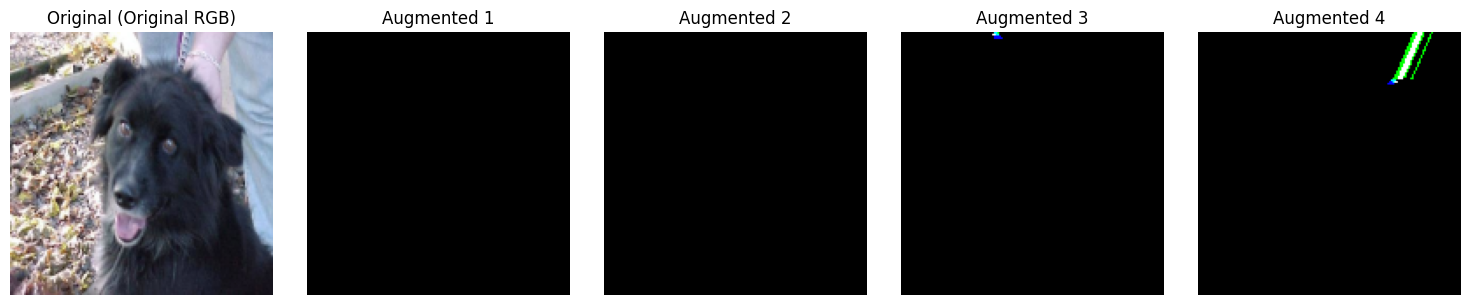

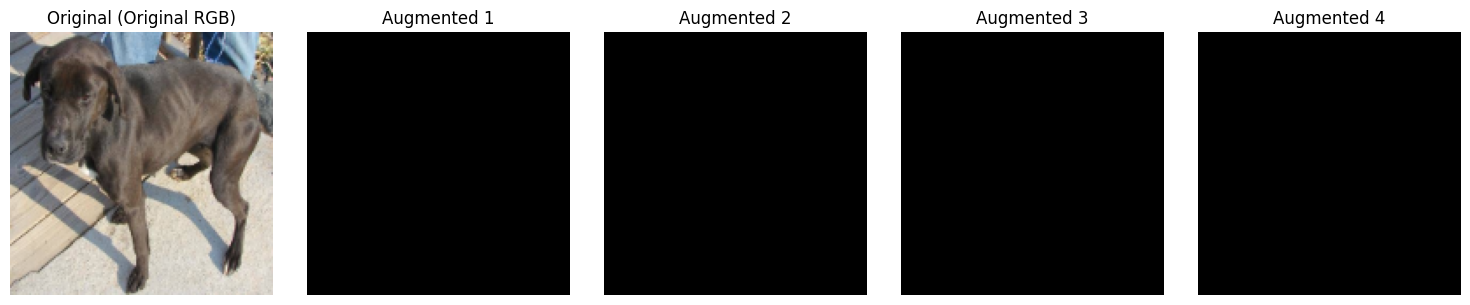

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 54s 205ms/step - accuracy: 0.5004 - loss: 0.9883 - val_accuracy: 0.5397 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 2/30
  1/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4062 - loss: 0.9501

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4062 - loss: 0.9501 - val_accuracy: 0.5320 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.4906 - loss: 0.7883
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
218/218 ━━━━━━━━━━━━━━━━━━━━ 38s 173ms/step - accuracy: 0.4906 - loss: 0.7883 - val_accuracy: 0.5077 - val_loss: 0.7765 - learning_rate: 0.0010
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 0.7533 - val_accuracy: 0.5077 - val_loss: 0.7668 - learning_rate: 5.0000e-04
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5103 - loss: 0.7339
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
218/218 ━━━━━━━━━━━━━━━━━━━━ 38s 173ms/step - accuracy: 0.5103 - loss: 0.7338 - val_accuracy: 0.4927 - val_loss: 0.8915 - learning_rate: 5.0000e-04
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 0.71

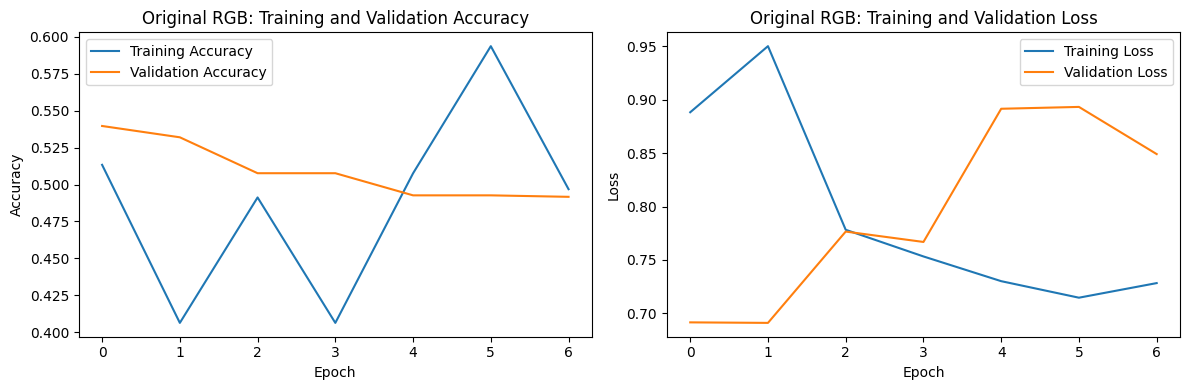

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


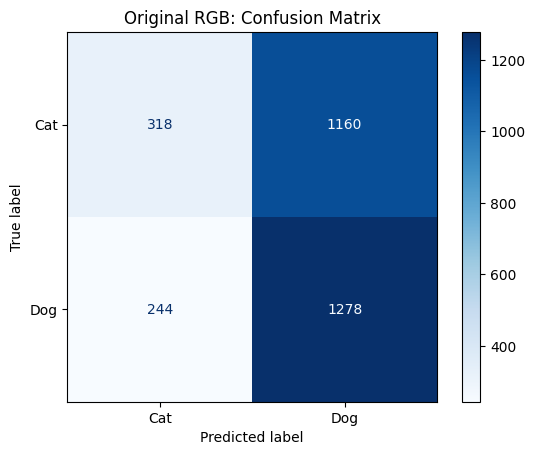

Accuracy: 0.5320
Precision: 0.5242
Recall: 0.8397
F1 Score: 0.6455


In [ ]:
# Dictionary to store results
model_results = {}

# 1. Original RGB Model
print("\nPreparing RGB images...")
X_original = preprocess_original(train_images, img_dim)
X_train_original, X_val_original, y_train_split, y_val_split = train_test_split(
    X_original, y_train, test_size=0.3, random_state=RANDOM_SEED)
model_results['Original RGB'] = train_and_evaluate_model(
    X_train_original, X_val_original, y_train_split, y_val_split, "Original RGB")


Preparing grayscale images...


100%|██████████| 10000/10000 [00:01<00:00, 5007.74it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)




===== Training Grayscale Model with Data Augmentation =====
Input shape: (150, 150, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 6,815,361 (26.00 MB)

 Trainable params: 6,813,377 (25.99 MB)

 Non-trainable params: 1,984 (7.75 KB)


Visualizing data augmentation for Grayscale:


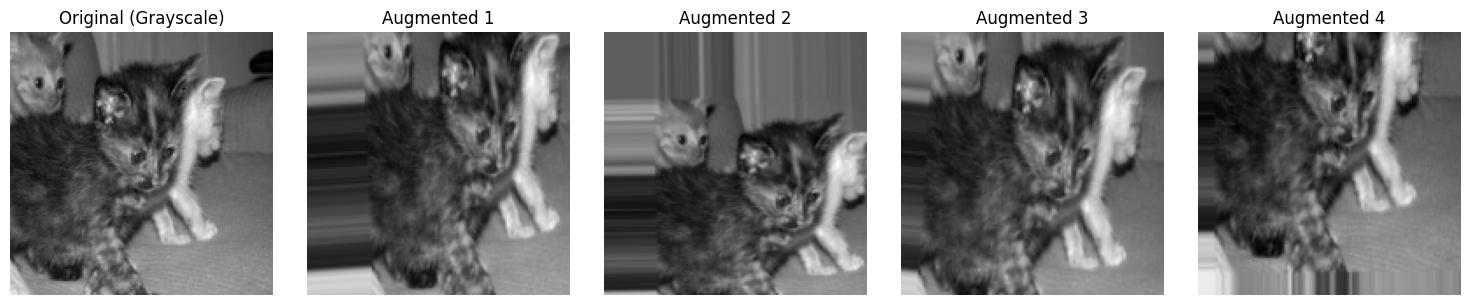

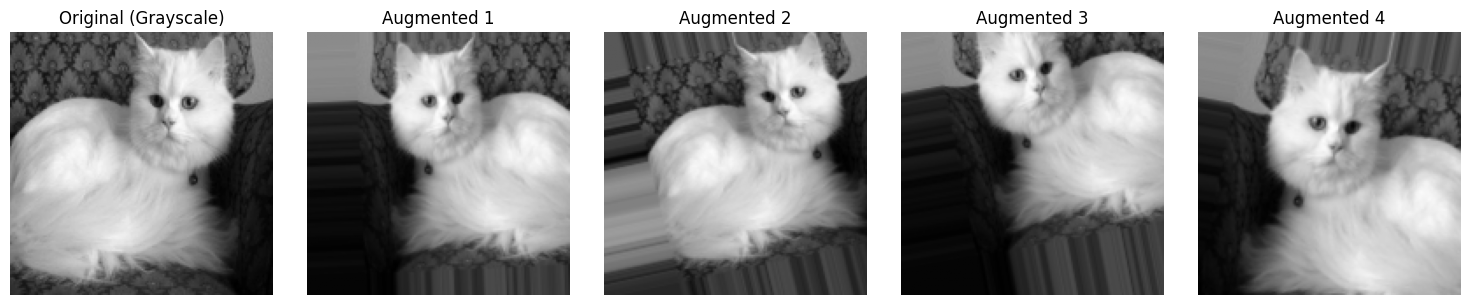

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.5587 - loss: 0.9462 - val_accuracy: 0.5483 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 2/30
  1/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5625 - loss: 0.6793

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 0.6793 - val_accuracy: 0.5307 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.6158 - loss: 0.6934 - val_accuracy: 0.6153 - val_loss: 0.6543 - learning_rate: 0.0010
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.6463 - val_accuracy: 0.6557 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.6477 - loss: 0.6310 - val_accuracy: 0.6340 - val_loss: 0.6796 - learning_rate: 0.0010
Epoch 6/30
  1/218 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6562 - loss: 0.5736
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.5736 - val_accuracy: 0.6537 - val_loss: 0.6507 - learning_rate: 0.0010
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.6840 - loss: 0.5977 - val_ac

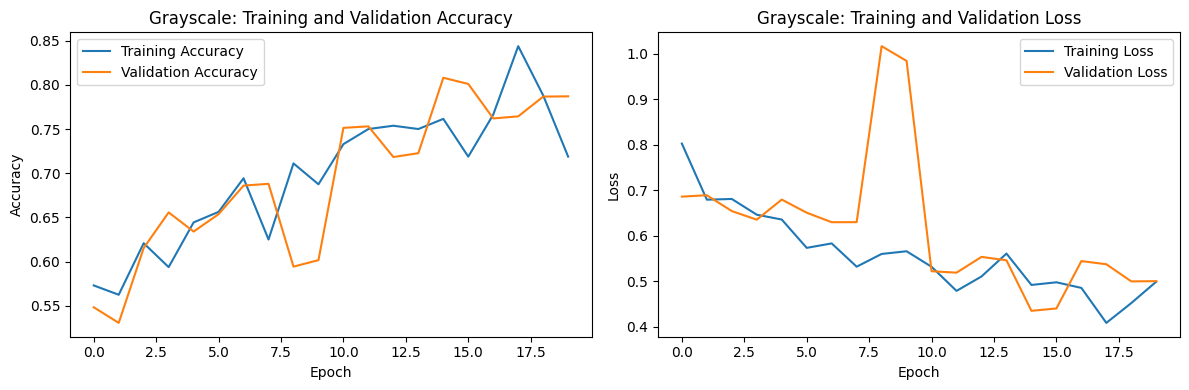

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


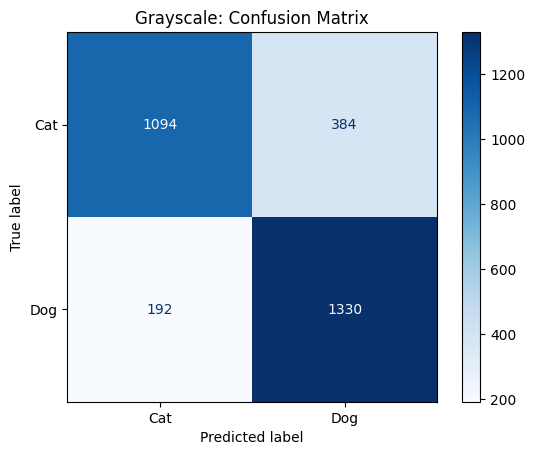

Accuracy: 0.8080
Precision: 0.7760
Recall: 0.8739
F1 Score: 0.8220


In [ ]:
# 2. Grayscale Model
print("\nPreparing grayscale images...")
X_gray = preprocess_grayscale(train_images, img_dim)
X_train_gray, X_val_gray, y_train_split, y_val_split = train_test_split(
    X_gray, y_train, test_size=0.3, random_state=RANDOM_SEED)
model_results['Grayscale'] = train_and_evaluate_model(
    X_train_gray, X_val_gray, y_train_split, y_val_split, "Grayscale")


Preparing blurred images...


100%|██████████| 10000/10000 [00:02<00:00, 3359.48it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)




===== Training Gaussian Blur Model with Data Augmentation =====
Input shape: (150, 150, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 6,815,361 (26.00 MB)

 Trainable params: 6,813,377 (25.99 MB)

 Non-trainable params: 1,984 (7.75 KB)


Visualizing data augmentation for Gaussian Blur:


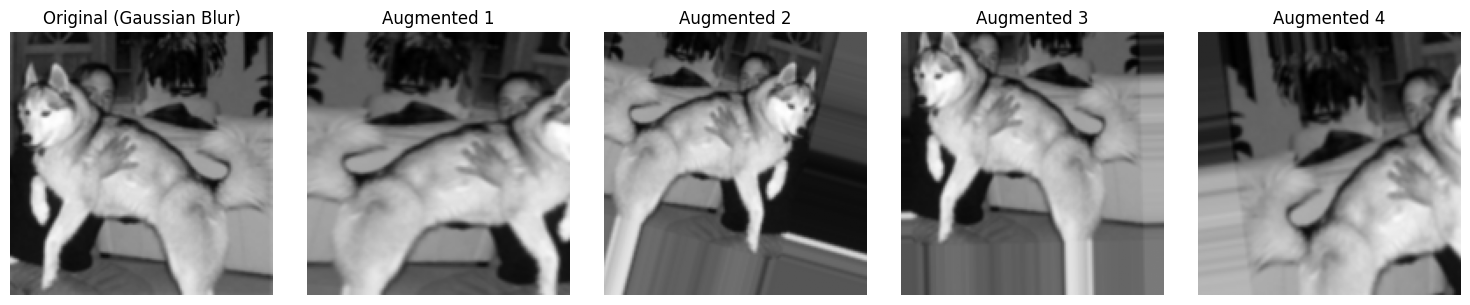

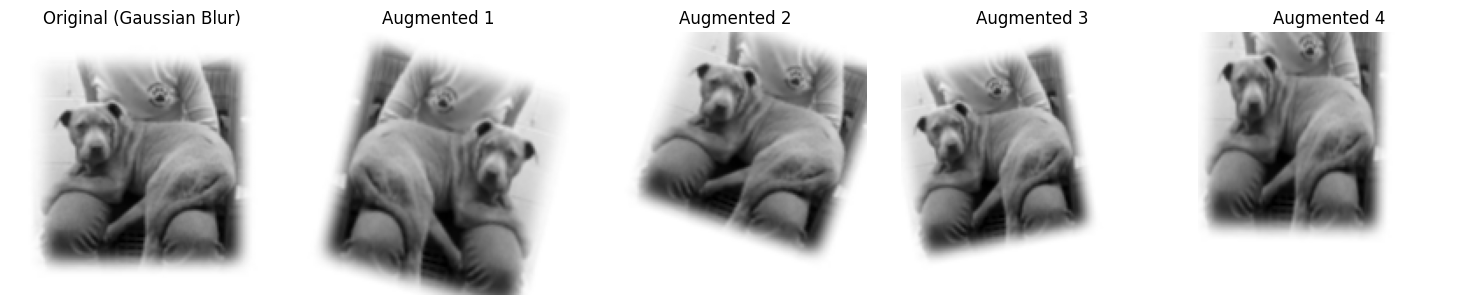

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 0.5608 - loss: 0.9309 - val_accuracy: 0.4927 - val_loss: 0.7841 - learning_rate: 0.0010
Epoch 2/30
  1/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5938 - loss: 0.6833

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.6833 - val_accuracy: 0.4927 - val_loss: 0.7966 - learning_rate: 0.0010
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.5765 - loss: 0.7122 - val_accuracy: 0.5317 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.6048 - val_accuracy: 0.5490 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.6244 - loss: 0.6607 - val_accuracy: 0.5870 - val_loss: 0.7084 - learning_rate: 0.0010
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 0.7919 - val_accuracy: 0.5847 - val_loss: 0.7024 - learning_rate: 0.0010
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.6359 - loss: 0.6361 - val_accuracy: 0.6073 - val_loss: 0.7113 - learning_rate: 0.0010
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.6067 - val_a

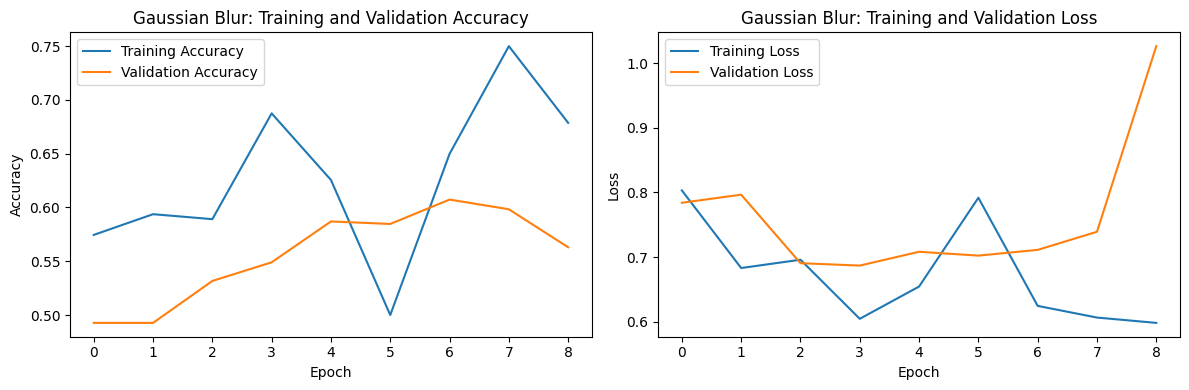

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


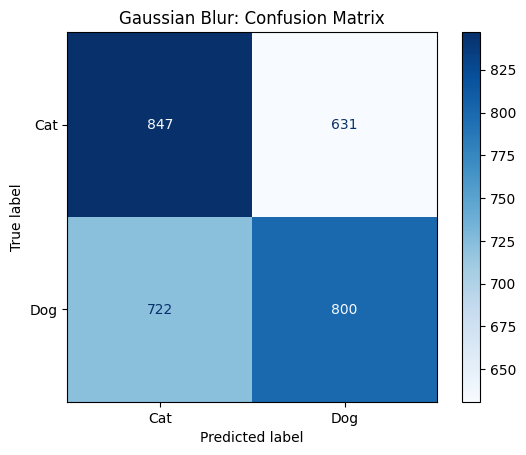

Accuracy: 0.5490
Precision: 0.5590
Recall: 0.5256
F1 Score: 0.5418


In [ ]:
# 3. Gaussian Blur Model
print("\nPreparing blurred images...")
X_blur = preprocess_blur(train_images, img_dim)
X_train_blur, X_val_blur, y_train_split, y_val_split = train_test_split(
    X_blur, y_train, test_size=0.3, random_state=RANDOM_SEED)
model_results['Gaussian Blur'] = train_and_evaluate_model(
    X_train_blur, X_val_blur, y_train_split, y_val_split, "Gaussian Blur")


Preparing edge images...


100%|██████████| 10000/10000 [00:04<00:00, 2395.11it/s]




===== Training Canny Edge Model with Data Augmentation =====
Input shape: (150, 150, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 6,815,361 (26.00 MB)

 Trainable params: 6,813,377 (25.99 MB)

 Non-trainable params: 1,984 (7.75 KB)


Visualizing data augmentation for Canny Edge:


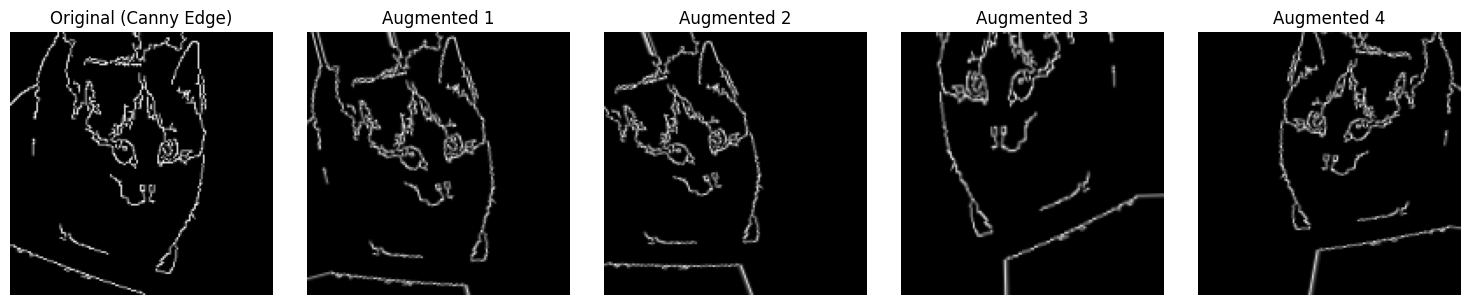

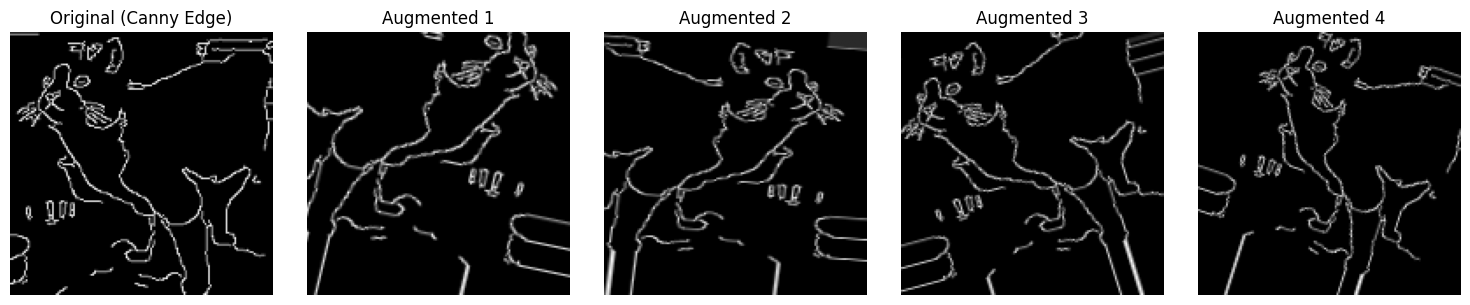

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.5714 - loss: 0.8690 - val_accuracy: 0.4920 - val_loss: 0.9429 - learning_rate: 0.0010
Epoch 2/30
  1/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5625 - loss: 0.7109

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 0.7109 - val_accuracy: 0.4927 - val_loss: 1.0243 - learning_rate: 0.0010
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.5828 - loss: 0.7045 - val_accuracy: 0.4933 - val_loss: 2.3038 - learning_rate: 0.0010
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.7208 - val_accuracy: 0.4937 - val_loss: 2.3084 - learning_rate: 0.0010
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.6433 - loss: 0.6513 - val_accuracy: 0.6420 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.5535 - val_accuracy: 0.6370 - val_loss: 0.7061 - learning_rate: 0.0010
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.6583 - loss: 0.6332 - val_accuracy: 0.7207 - val_loss: 0.5481 - learning_rate: 0.0010
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.6187 - val_a

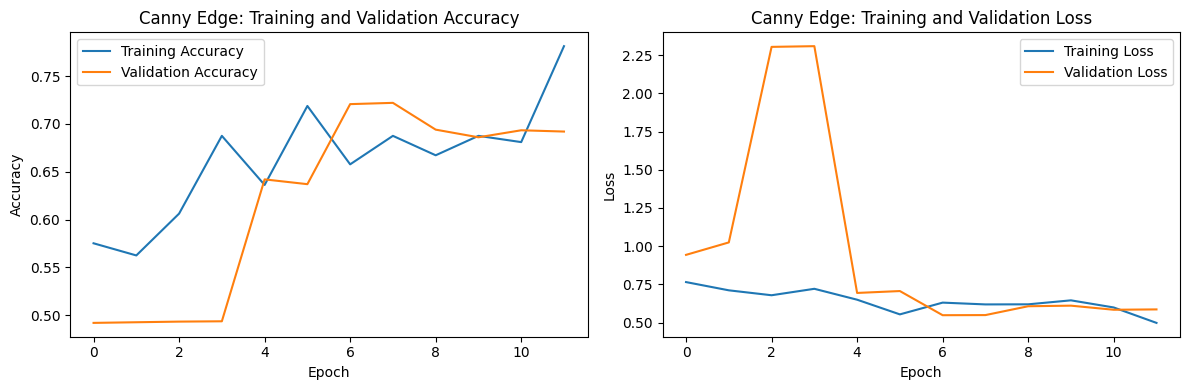

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


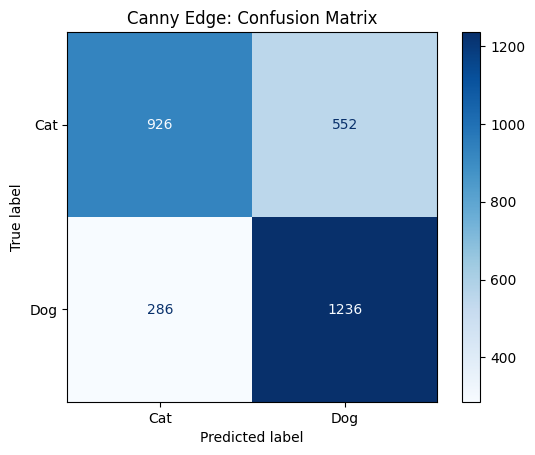

Accuracy: 0.7207
Precision: 0.6913
Recall: 0.8121
F1 Score: 0.7468


In [ ]:

# 4. Canny Edge Model
print("\nPreparing edge images...")
X_edge = preprocess_edge(train_images, img_dim)
X_train_edge, X_val_edge, y_train_split, y_val_split = train_test_split(
    X_edge, y_train, test_size=0.3, random_state=RANDOM_SEED)
model_results['Canny Edge'] = train_and_evaluate_model(
    X_train_edge, X_val_edge, y_train_split, y_val_split, "Canny Edge")


Preparing HOG images...


100%|██████████| 10000/10000 [03:20<00:00, 49.81it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)




===== Training HOG Model with Data Augmentation =====
Input shape: (150, 150, 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 6,815,361 (26.00 MB)

 Trainable params: 6,813,377 (25.99 MB)

 Non-trainable params: 1,984 (7.75 KB)


Visualizing data augmentation for HOG:


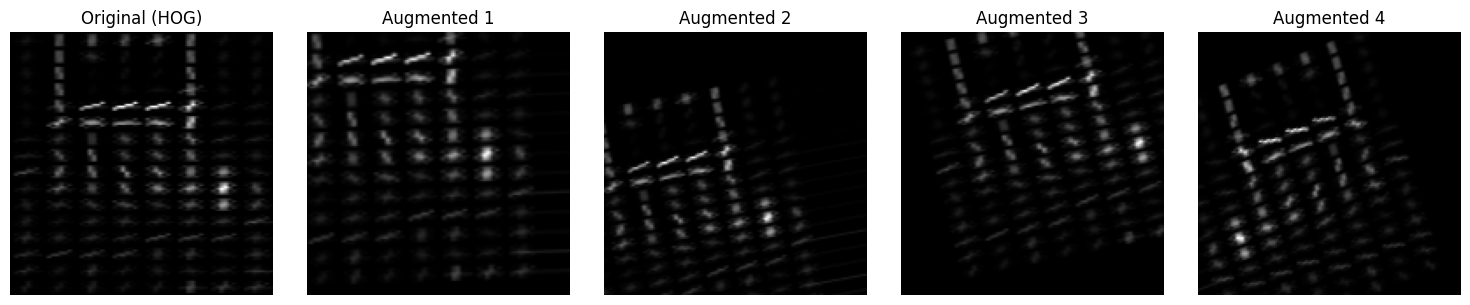

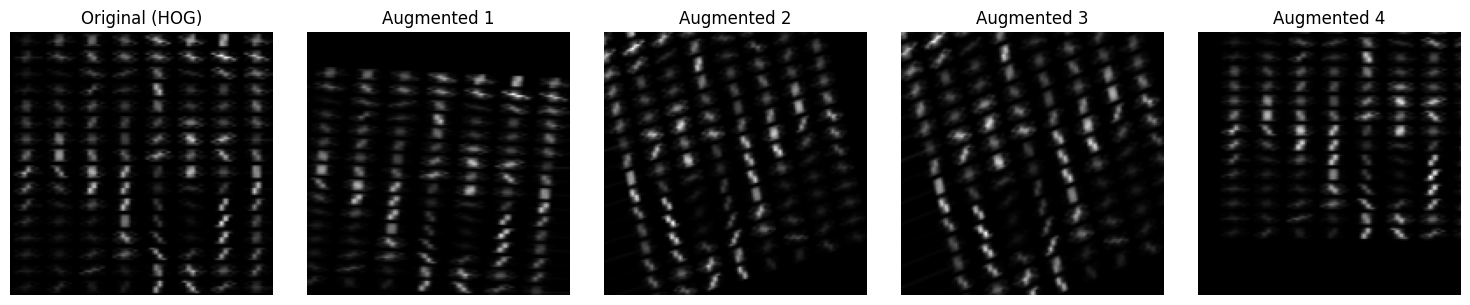

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.5458 - loss: 0.9436 - val_accuracy: 0.5093 - val_loss: 0.7379 - learning_rate: 0.0010
Epoch 2/30
  1/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6250 - loss: 0.6128

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.6128 - val_accuracy: 0.5623 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.5676 - loss: 0.7235 - val_accuracy: 0.5323 - val_loss: 0.7333 - learning_rate: 0.0010
Epoch 4/30
  1/218 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6250 - loss: 0.7002
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.7002 - val_accuracy: 0.5530 - val_loss: 0.7086 - learning_rate: 0.0010
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.6148 - loss: 0.6662 - val_accuracy: 0.5277 - val_loss: 0.8734 - learning_rate: 5.0000e-04
Epoch 6/30
  1/218 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5938 - loss: 0.6302
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.6302 - val_a

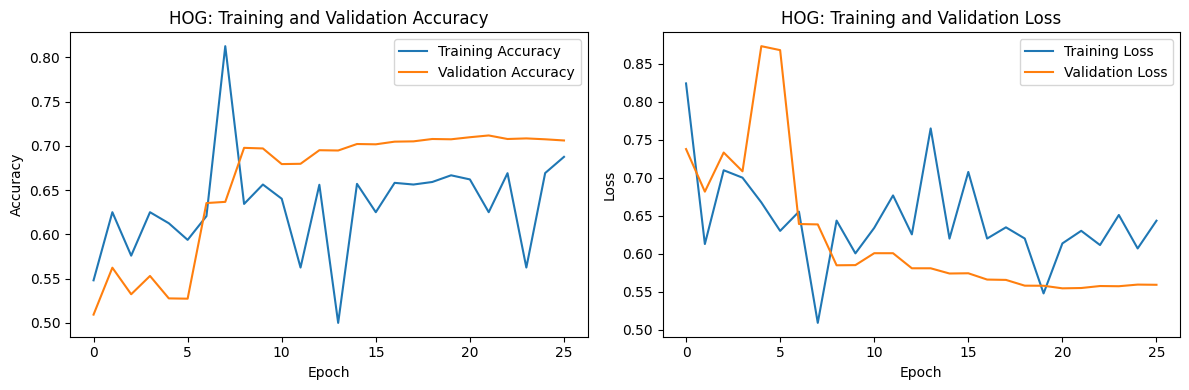

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


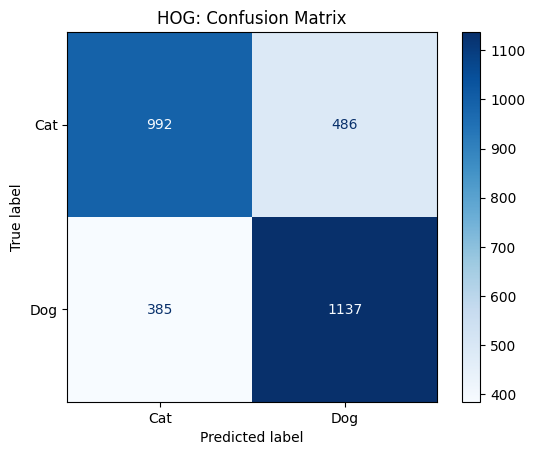

Accuracy: 0.7097
Precision: 0.7006
Recall: 0.7470
F1 Score: 0.7231


In [ ]:

# 5. HOG Model
print("\nPreparing HOG images...")
X_hog = preprocess_hog(train_images, img_dim)
X_train_hog, X_val_hog, y_train_split, y_val_split = train_test_split(
    X_hog, y_train, test_size=0.3, random_state=RANDOM_SEED)
model_results['HOG'] = train_and_evaluate_model(
    X_train_hog, X_val_hog, y_train_split, y_val_split, "HOG")


Preparing combined images...


100%|██████████| 10000/10000 [00:04<00:00, 2266.74it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)




===== Training Combined Model with Data Augmentation =====
Input shape: (150, 150, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 6,815,361 (26.00 MB)

 Trainable params: 6,813,377 (25.99 MB)

 Non-trainable params: 1,984 (7.75 KB)


Visualizing data augmentation for Combined:


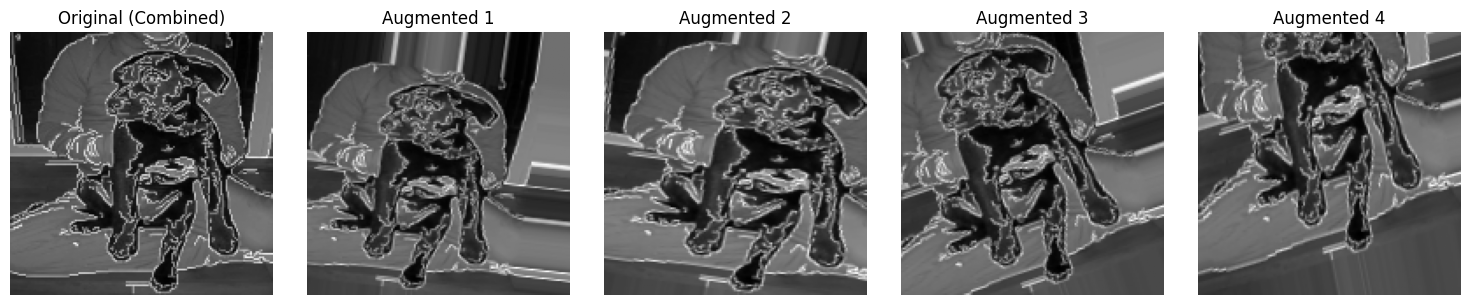

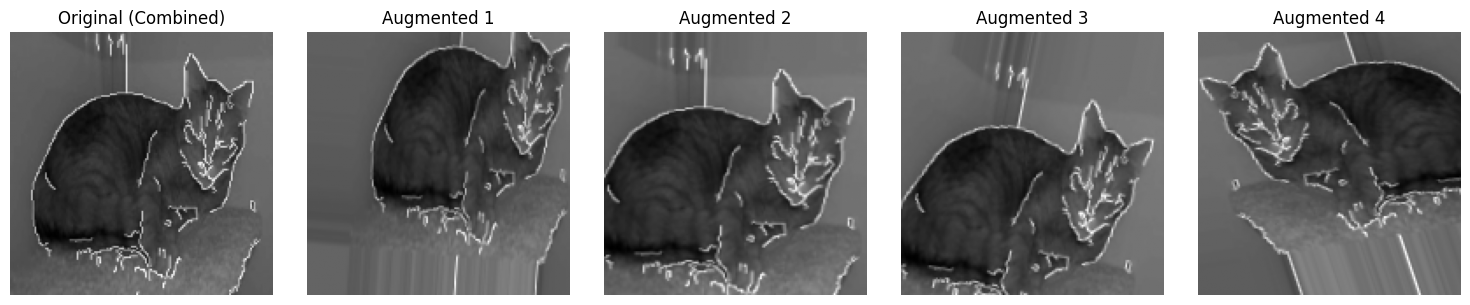

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.5776 - loss: 0.9194 - val_accuracy: 0.4927 - val_loss: 2.3968 - learning_rate: 0.0010
Epoch 2/30
  1/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5312 - loss: 0.9823

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 0.9823 - val_accuracy: 0.4927 - val_loss: 2.2111 - learning_rate: 0.0010
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.6197 - loss: 0.6749 - val_accuracy: 0.5110 - val_loss: 0.8097 - learning_rate: 0.0010
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7083 - loss: 0.5925 - val_accuracy: 0.5080 - val_loss: 0.8274 - learning_rate: 0.0010
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.6342 - loss: 0.6546 - val_accuracy: 0.6583 - val_loss: 0.6177 - learning_rate: 0.0010
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.6029 - val_accuracy: 0.6407 - val_loss: 0.6295 - learning_rate: 0.0010
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.6586 - loss: 0.6188 - val_accuracy: 0.6650 - val_loss: 0.6325 - learning_rate: 0.0010
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.7211 - val_a

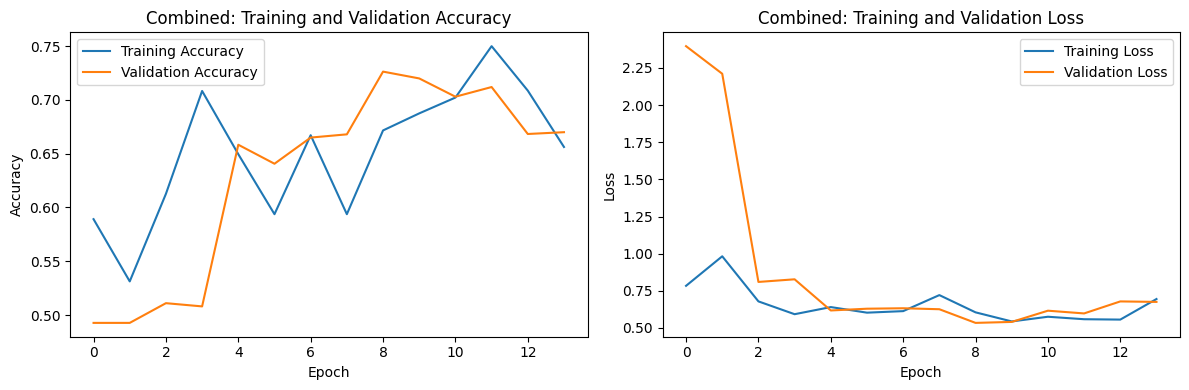

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


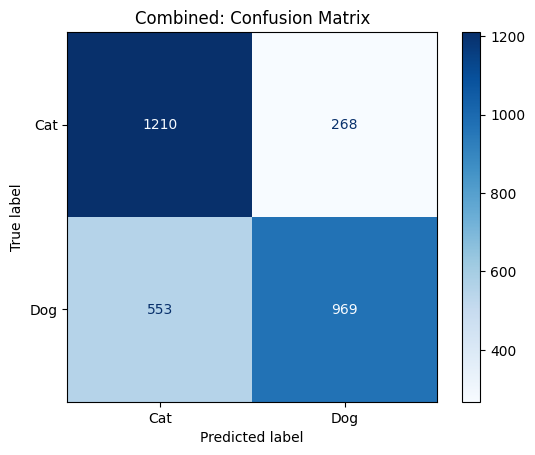

Accuracy: 0.7263
Precision: 0.7833
Recall: 0.6367
F1 Score: 0.7024


In [ ]:


# 6. Combined Model
print("\nPreparing combined images...")
X_combined = preprocess_combined(train_images, img_dim)
X_train_combined, X_val_combined, y_train_split, y_val_split = train_test_split(
    X_combined, y_train, test_size=0.3, random_state=RANDOM_SEED)
model_results['Combined'] = train_and_evaluate_model(
    X_train_combined, X_val_combined, y_train_split, y_val_split, "Combined")

##RESULT AND EVALUATIONN



===== Model Comparison =====
           Model  Accuracy  Precision    Recall  F1 Score
0   Original RGB  0.532000   0.524200  0.839685  0.645455
1      Grayscale  0.808000   0.775963  0.873850  0.822002
2  Gaussian Blur  0.549000   0.559050  0.525624  0.541822
3     Canny Edge  0.720667   0.691275  0.812089  0.746828
4            HOG  0.709667   0.700555  0.747043  0.723052
5       Combined  0.726333   0.783347  0.636662  0.702428

Best model based on accuracy: Grayscale


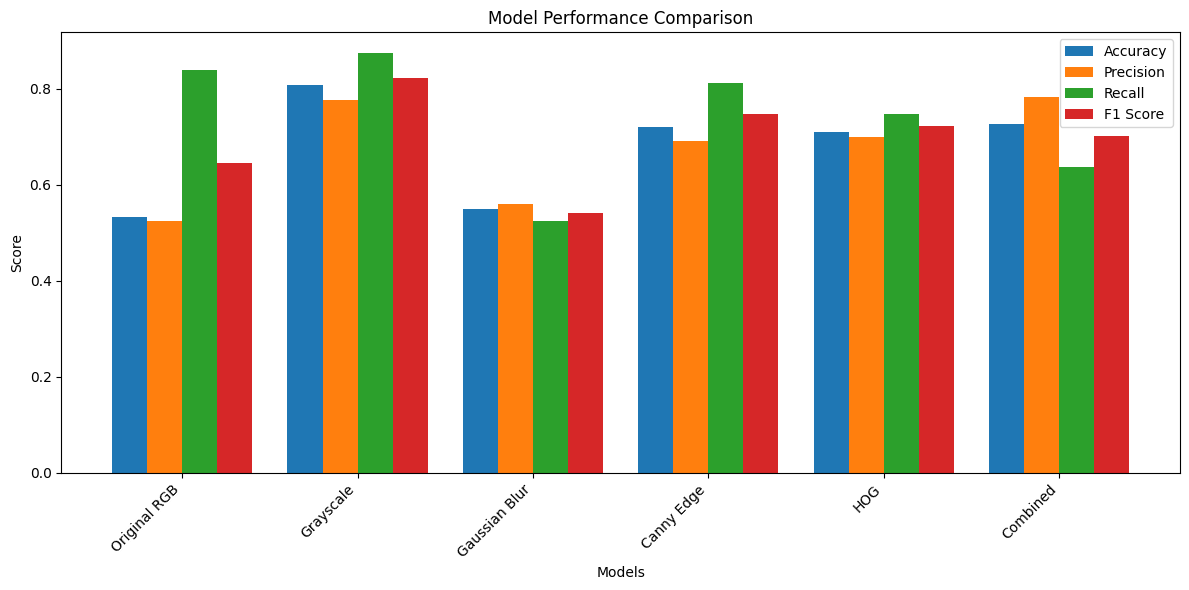



===== Generating Predictions Using the Best Model =====


100%|██████████| 1000/1000 [00:00<00:00, 5332.16it/s]


In [ ]:


# Compare model performances
print("\n\n===== Model Comparison =====")
models = list(model_results.keys())
accuracies = [model_results[model]['accuracy'] for model in models]
precisions = [model_results[model]['precision'] for model in models]
recalls = [model_results[model]['recall'] for model in models]
f1_scores = [model_results[model]['f1'] for model in models]

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})
print(comparison_df)

# Find the best model based on accuracy
best_model_idx = np.argmax(accuracies)
best_model_name = models[best_model_idx]
print(f"\nBest model based on accuracy: {best_model_name}")

# Plot comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.2

plt.bar(x - 1.5*width, accuracies, width, label='Accuracy')
plt.bar(x - 0.5*width, precisions, width, label='Precision')
plt.bar(x + 0.5*width, recalls, width, label='Recall')
plt.bar(x + 1.5*width, f1_scores, width, label='F1 Score')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Select the best model for predictions on test data
print("\n\n===== Generating Predictions Using the Best Model =====")
best_model = model_results[best_model_name]['model']

# Prepare test data with the same preprocessing as the best model
if best_model_name == 'Original RGB':
    X_test_processed = preprocess_original(test_images, img_dim)
elif best_model_name == 'Grayscale':
    X_test_processed = preprocess_grayscale(test_images, img_dim)
elif best_model_name == 'Gaussian Blur':
    X_test_processed = preprocess_blur(test_images, img_dim)
elif best_model_name == 'Canny Edge':
    X_test_processed = preprocess_edge(test_images, img_dim)
elif best_model_name == 'HOG':
    X_test_processed = preprocess_hog(test_images, img_dim)
else:  # Combined
    X_test_processed = preprocess_combined(test_images, img_dim)

100%|██████████| 1000/1000 [00:00<00:00, 5654.98it/s]



Making predictions on test data...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Sample predictions:
   id label
0   1   dog
1   2   cat
2   3   cat
3   4   cat
4   5   dog
5   6   dog
6   7   dog
7   8   cat
8   9   cat
9  10   dog

Visualizing sample predictions:


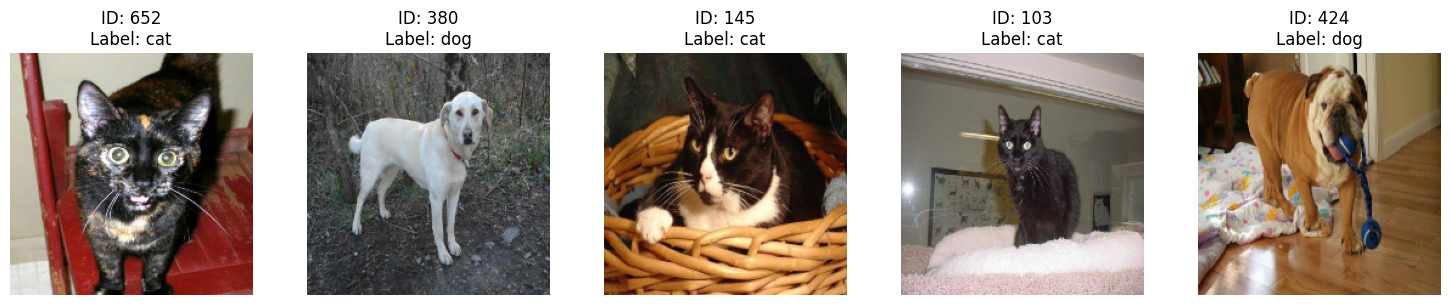


Predictions saved to /content/drive/MyDrive/Colab Notebooks/BCU/Applied AI/Image Processing Assessment/Prediction Challenge - Image Processing-20250218/data/test-predictions.csv


In [ ]:
# # Read csv file into a dataframe
# df_test = pd.read_csv(os.path.join(data_folder, 'test.csv'))

# # Load test images and resize them to the base size used with training images
# print("\nLoading and preprocessing test images...")
# test_images = load_images(df_test['id'], test_image_folder, base_dim)

# Get features for test images following the same procedure used with training images
features_list = []
if best_model_name == 'Original RGB':
    features_list = preprocess_original(test_images, img_dim)
elif best_model_name == 'Grayscale':
    features_list = preprocess_grayscale(test_images, img_dim)
elif best_model_name == 'Gaussian Blur':
    features_list = preprocess_blur(test_images, img_dim)
elif best_model_name == 'Canny Edge':
    features_list = preprocess_edge(test_images, img_dim)
elif best_model_name == 'HOG':
    features_list = preprocess_hog(test_images, img_dim)
else:  # Combined
    features_list = preprocess_combined(test_images, img_dim)

# Make predictions using the best model
print("\nMaking predictions on test data...")
predictions = best_model.predict(features_list)
test_predictions = (predictions > 0.5).astype("int32").flatten()

# Convert numeric predictions back to labels
prediction_labels = ['cat' if pred == 0 else 'dog' for pred in test_predictions]

# Add predictions to the 'label' column
df_test['label'] = prediction_labels

# Make sure there's no 'prediction' column (in case it exists from previous runs)
if 'prediction' in df_test.columns:
    df_test = df_test.drop('prediction', axis=1)

# Keep only the needed columns
df_test = df_test[['id', 'label']]

# Display sample predictions
print("\nSample predictions:")
print(df_test.head(10))

# Visualize some test predictions
def visualize_test_predictions(images, ids, labels, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
        plt.title(f"ID: {ids[idx]}\nLabel: {labels[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nVisualizing sample predictions:")
visualize_test_predictions(test_images, df_test['id'].values, df_test['label'].values)

# Save data frame to .csv file
output_path = os.path.join(data_folder, 'test-predictions.csv')
df_test.to_csv(output_path, index=False)
df_test.to_csv('/content/test-predictions.csv', index=False)
print(f"\nPredictions saved to {output_path}")